In [1]:

import numpy as np

import ngsolve 
from ngsolve.webgui import Draw
import netgen.geom2d

# some helpful websites on ngsolve

https://docu.ngsolve.org/latest/index.html

https://docu.ngsolve.org/ngs24/intro.html

https://docu.ngsolve.org/latest/i-tutorials/index.html

https://jschoeberl.github.io/iFEM/iterative/Richardson.html

https://simonstingelin.github.io/NGSUserMeeting24/ExamplePage.html

https://app.readthedocs.org/projects/ngs-py/downloads/pdf/latest/


# Solving Reaction Diffusion equation pattern formation PDEs with a finite element method

We have two scalar fields $u,v$ in domain $\Omega$ that are also functions of time. 
The problem we will solve is the reaction diffusion equations 
\begin{align}
\partial_t u &= D_u \Delta u + R_u(u,v) \qquad \in \Omega\\
\partial_t v &= D_v \Delta v + R_v(u,v) 
\end{align}
For the Brusselator model the reactions between the two fields are the non-linear functions 
\begin{align}
R_u(u,v) &=  \alpha - (\beta+1) u + u^2 v \\    
    R_v(u,v) &= \beta u - u^2 v
\end{align}
Here $D_u,D_v$ are diffusion coefficients and $\alpha, \beta$ are parameters for the reaction part of the model.
For certain values of $\alpha, \beta$, random but small initial conditions, when evolved, become patterns. 

The coupled PDE for the Brusselator model is obeyed in the domain $\Omega$, 
but on the boundary  $\partial \Omega$ we set $\frac{\partial u}{\partial n} = \frac{\partial u}{\partial n} = 0 $. 
This is a Neumann boundary condition. 

The weak/variational form of the problem is 
\begin{align}
\int_\Omega \partial_t u\ w_u\ dx &= \int_\Omega D_u (\Delta u) w_u \ dx + \int_\Omega R_u(u,v)w_u \ dx\\
\int_\Omega \partial_t v\ w_v\ dx &= \int_\Omega D_v (\Delta v) w_v \ dx + \int_\Omega R_v(u,v)w_v \ dx
\end{align}
for all test functions $w_u, w_v \in \hat V$ where we will define $\hat V$.  
We integrate by parts the terms that contain a Laplacian operator 
\begin{align}
\int_\Omega \partial_t u\ w_u \ dx =   - D_u  \int_\Omega \nabla u \nabla w_u \ dx 
+ D_u\int_{\partial \Omega} \nabla u\ w_u \ ds
+  \int_\Omega R_u(u,v)w_u \ dx \\
 \int_\Omega \partial_t v\ w_v \ dx =  - D_v \int_\Omega \nabla v \nabla w_v \ dx 
+ D_v \int_{\partial \Omega} \nabla v\ w_v \ ds
+  \int_\Omega R_v(u,v)w_v \ dx 
\end{align}
With normal derivatives of $u,v$ equal to zero on the boundary, the two boundary terms in the above
equations can be neglected.
The weak form should be obeyed for all test functions $w \in \hat V$ with $\hat V = H^1(\Omega)$.
Since we lack Dirichlet regions of the boundary, there is no additional condition on $\hat V$. 
 We are following section 2.2.1 of the Fenics book.

We use a discrete subspace for $\hat V$ and assume we have a nice basis for it. 
We write each term as if it were an operator acting on a vector $w$ (aka the test function) in this basis. 

We split each time step into two pieces.  First updating $u,v$ with an implicit Crank-Nicholson step and 
then we take a first order forward Eulerian step to take into account the functions $R_u, R_v$. 

The Crank-Nicolson step for  $\partial_t u = F u  $  with $F$ a linear op is the following scheme 
\begin{align}
\partial_t u \sim \frac{u^{n+1} - u^n}{\Delta t} = \frac{1}{2} \left(F u^{n+1} + F u^n\right)
\end{align}
\begin{align}
\left( 1 - \frac{\Delta t F}{2 } \right) u^{n+1} = \left(1 + \frac{\Delta t F}{2 } \right) u^n \end{align}
\begin{align}
u^{n+1} = \left( 1 - \frac{ \Delta tF}{2} \right)^{-1} \left(1 + \frac{\Delta t F}{2 } \right)u^n
\end{align}
In the limit of small $\Delta t$ this is equivalent to a foward Eulerian scheme. 

With $m(u,v) = \int u v dx  = M u $ a mass operator and $a(u,v) = \int \nabla u \nabla v dx  = -F u $  a Laplacian operator
The above scheme becomes 
\begin{align}
u^{n+1} = \left( M - \frac{ \Delta tF}{2} \right)^{-1} \left(M + \frac{\Delta t F}{2 } \right)u^n
\end{align}

Taking into account the reaction equations for a diffusion reaction system 
\begin{align}
u^{n+1} &= \left( 1 - \frac{ \Delta t}{2 }D_u L \right)^{-1} \left(1 + \frac{\Delta t}{2 }D_uL  \right)u^n + 
\Delta t R_u(u^n,v^n)\\
v^{n+1} &= \left( 1 - \frac{\Delta t }{2 } D_v L\right)^{-1} \left(1 + \frac{\Delta t}{2 } D_vL\right)v^n + 
\Delta t R_v(u^n,v^n)
\end{align}
where $L$ is minus the Laplacian operator. 


For our system 
\begin{align}
b &= M - \frac{\Delta t}{2} A\\
A* &= M +\frac{\Delta t}{2} A
\end{align}
with 
\begin{align}
M(u,v,w_u, w_v) & = \int (u w_u +  v  w_v) dx \\
A(u,v,w_u,w_v) & = \int (D_u \nabla u \nabla w_u + D_v \nabla v \nabla w_v) dx
\end{align}



# A pattern formation model finite element model with NGsolve!

In [2]:
# Reaction parts of differential equations for 
# different types of different Reaction diffusion equations
# u,v are scalar fields, alpha, beta could be numbers or arrays with same dimension as fields
# rdtype is a string specifying the model
def Reaction(u,v,alpha,beta,rdtype):
    if (rdtype == 'FN'):  # FitzHugh Nagumo model
        Ru,Rv=R_FN(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Br'):  # Brusellator model
        Ru,Rv= R_Br(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'GS'):  # Gray-Scott model
        Ru,Rv = R_GS(u,v,alpha,beta)
        return Ru,Rv
    if (rdtype == 'Ba'):   # Barkley model 
        epsilon = 0.02  # choosing this value
        Ru,Rv = R_Ba(u,v,alpha,beta,epsilon)
        return Ru,Rv
    if (rdtype == 'Heat'):  # Heat equation 
        n = len(u)
        Ru = np.zeros(n); Rv = np.zeros(n)
        return Ru,Rv
    print('invalid reaction type')

#The FitzHugh-Nagumo Reaction Diffusion Model
# example: Du, Dv, alpha, beta = 1, 10, 0.1, 1, dt=0.01, dx = 1
def R_FN(u,v,alpha,beta): 
    Ru =  u - u**3 - v + alpha 
    Rv = (u - v)*beta
    return Ru,Rv
    
# Brusselator Reaction Diffusion model
# example: Du, Dv, alpha, beta = 2, 22, 5, 9 # dt=0.005, dx=1
# u = alpha, v = beta/alpha is a fixed point of R
def R_Br(u,v,alpha,beta): 
    Ru = alpha - (beta+1)*u + (u**2)*v    
    Rv = beta*u - (u**2)*v
    return Ru,Rv

# The Gray-Scott Reaction Diffusion model
# alpha is feed rate for u and kills v, beta is kill or drain rate for v
# example: Du = 0.2, Dv = Du/2, alpha = 0.037 and beta = 0.06 , dx=1
def R_GS(u,v,alpha,beta): 
    Ru =  -u*(v**2) + alpha*(1-u) 
    Rv =  u*(v**2) -(alpha+ beta)*v
    return Ru,Rv

# the Barkley model 
# http://www.scholarpedia.org/article/Barkley_model
# example epsilon=0.02, alpha = 0.75, beta = 0.02, domain = 200, dt = 0.01
def R_Ba(u,v,alpha,beta,epsilon): 
    Ru =  (1/epsilon)*u*(1-u)*(u - (v + beta)/alpha) 
    Rv =  u-v
    return Ru,Rv

In [3]:
# https://docu.ngsolve.org/latest/i-tutorials/unit-4.1.2-csg2d/csg2d.html
geo = netgen.geom2d.CSG2d()

# make a circle with a hole in it!
circle1 = netgen.geom2d.Circle( center=(0,0), radius=1.0,  bc="outer" )
circle2 = netgen.geom2d.Circle( center=(0.1,0), radius=0.3,  bc="inner" )

annulus = circle1 - circle2
geo.Add(annulus)

# generate the  mesh
maxh_mesh = 0.03  # max distance between nodes?
mmesh = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh))  # maxh here sets the scale of elements 
print(f"vertices={mmesh.nv}, edges ={mmesh.ne}")  # print numbers of vertices and edges!

Draw(mmesh) # show the mesh

vertices=3551, edges =6830


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [7]:
# create finite element system 'fes'  - we have two fields for the reaction diffusion equations 
korder = 3
Q1 = ngsolve.H1(mmesh, order=korder)   # Choose an element that is in the Sobolev space H1, first field
Q2 = ngsolve.H1(mmesh, order=korder)   # second field
fes = Q1*Q2   # our finite element space is the product of the two spaces 
(u1,u2),(v1,v2)  = fes.TnT()  # create test and trial functions  
# The two test fields are u1,u2 and the trial functions are v1,v2
# in our equations the fields were u,v but here we have u=u1 and v=u2     
# in our equations the trial functions were both w, and here they are v1 and v2

gfu = ngsolve.GridFunction(fes) # to hold the solution 

# output fields 
u1_out = gfu.components[0]
u2_out = gfu.components[1]

In [5]:
# create operators 
def mkops(fes,D_u,D_v,dt):
    a = ngsolve.BilinearForm(fes)  # holds Laplacian operator for both fields 
    a += 1*D_u*ngsolve.grad(u1)*ngsolve.grad(v1)*ngsolve.dx # This is laplacian with a diffusion coef on the first field
    a += 1*D_v*ngsolve.grad(u2)*ngsolve.grad(v2)*ngsolve.dx # second field
    a.Assemble()

    m = ngsolve.BilinearForm(fes, symmetric=False)  # hold mass matrix for both fields 
    m += u1*v1*ngsolve.dx + u2*v2*ngsolve.dx
    m.Assemble()

    im = m.mat.CreateMatrix()
    invm = im.Inverse(freedofs=fes.FreeDofs())  # in case we want an inverse!

    print(f"m.mat.nze = {m.mat.nze}, a1.mat.nze={a.mat.nze}") # check that they are the same
    # these are the number of nonzero elements in the sparse matrices

    # B = M - 0.5*L*dt , needed for Crank Nicholson update L = Laplacian times diffusion coeff, M = mass matrix
    b = m.mat.CreateMatrix()
    b.AsVector().data     = m.mat.AsVector() - 0.5*dt * a.mat.AsVector()
    print(f"b.nze = {b.nze}")

    # A* = M + 0.5 * L * dt   needed for Crank Nicholson update 
    astar = m.mat.CreateMatrix() # create a matrix in the form of m
    astar.AsVector().data = m.mat.AsVector() + 0.5*dt * a.mat.AsVector()
    invastar = astar.Inverse(freedofs=fes.FreeDofs())
    print(f"astar.nze={astar.nze}")
    return invastar,b,invm



In [8]:
dt = 0.01  # timestep
D_u = 1.0e-3  # diffusion coefficients for reaction diffusion equations 
D_v = D_u*11
rdtype = 'Br'   # doing a Brusselator reaction diffusion model 
print(maxh_mesh**2/D_u,maxh_mesh**2/D_v )  # both of these should be larger than dt
# this is a CFL like condition for numerical stability
# CHECK that our dt is lower than these !!!!!!

# we define dt, D_u, D_v here because we need them to construct matrices 
# no boundary condition is yet specified which means we have a natural (zero Neumann) boundary condition 

# make the operators 
invastar,b,invm = mkops(fes,D_u,D_v,dt)

0.8999999999999999 0.08181818181818182
m.mat.nze = 2098140, a1.mat.nze=2098140
b.nze = 2098140
astar.nze=2098140


In [16]:
# arguments:
#  gfu :     # for holding solution, is a Gridfunction on a predefined mesh
#  invastar, b,invm :      # matrix operators on the finite element system 
#  nsamples:  number of outputs to store in the multidimensional data set 
#  rdtype: type of Reaction diffusion equation, is a string
#  alpha, beta: parameters for the reaction diffusion equation 
#  dt:        timestep  which is used in the matrix operators invastar and b 
#  reaction_by_hand:  how reactions are applied  (True/False)
# predefined things:
#  scene1 or and scene2  # for drawing fields, outputs of Draw ngsolve.webgui
# returns 
#  gfut:   a multidimensional set of grid functions on finite element system that holds time stepped results
# globals: 
#   test and trial functions u1,u2,v1,v2  if reaction_by_hand = False
#   Reaction() if reaction_by_hand = True
#reaction_by_hand=False  # now works!
def TimeStepping_CN(gfu, invastar, b, invm, rdtype, alpha, beta, dt, initial_cond = None, t0 = 0, tend = 10, 
                 nsamples = 20,reaction_by_hand = True):
    if initial_cond:
        gfu.Set(initial_cond)   # set initial condition, otherwise don't touch the initial fields 
        # as the initial condition could be set already in gfu.vec.data
    cnt = 0; time = t0
    sample_int = int(np.floor(tend / dt / nsamples)+1)  # nsamples seems to be the number of outputs we want
    
    gfut = ngsolve.GridFunction(gfu.space,multidim=0)
    gfut.AddMultiDimComponent(gfu.vec)  #  so we can store a series of solutions 
    
    # create a nonlinear operator for the reactions
    if (reaction_by_hand==False):
        reaction =  ngsolve.BilinearForm(fes, nonassemble=True)
        if (rdtype=='Br'):
            Ru = (alpha*v1 - (beta+1)*u1 + u1*u1*u2 )*v1
            Rv = (beta*u1 - u1*u1*u2)*v2
            # Ru = alpha - (beta+1)*u + (u**2)*v    becomes alpha - (beta+1)*u1  + u1^2 * u2 for the Brusselator!
            # Rv = beta*u - (u**2)*v
        if (rdtype=='GS'):
            Ru = (alpha*(1-u1) - u1*u2*u2 )*v1
            Rv = (u1*u2*u2 - (alpha + beta)*u2 )*v2 
            #Ru =  -u*(v**2) + alpha*(1-u)  Gray Scot 
            #Rv =  u*(v**2) -(alpha+ beta)*v
        if (rdtype=='FN'):
            Ru = (u1 - u1*u1*u1 - u2 + alpha )*v1
            Rv = (u1 - u2)*beta*v2 
            #Ru =  u - u**3 - v + alpha   Fitzhugh Nagumo
            #Rv = (u - v)*beta
        reaction += Ru*ngsolve.dx + Rv*ngsolve.dx

    while time < tend - 0.5 * dt:
        if (reaction_by_hand==False):
            reaction.Assemble()  # linearization is somehow done automatically here I think 
            
        res =  b * gfu.vec   # you can just multiply b onto gfu.vec (it is a matrix multiply!) # if b is just a matrix
        # res is defined here and is now a vector on the finite element system 
        gfu.vec.data = invastar * res  # replacing solution here for Crank Nicholson update  
        # note you can just multiply invastar onto res  (this is a matrix multiply!)

        if (reaction_by_hand==True):
            # operator split add in non-linear part by hand 
            upass = gfu.components[0].vec.FV().NumPy()[:]  # get the first field
            vpass = gfu.components[1].vec.FV().NumPy()[:]  # get the second field 
            Ru,Rv = Reaction(upass,vpass,alpha,beta,rdtype)  # compute the nonlinear reactions 
            gfu.components[0].vec.FV().NumPy()[:] += dt*Ru
            gfu.components[1].vec.FV().NumPy()[:] += dt*Rv
            # why I am doing this by hand?  NGsolve has non linear examples but I think they linearize and we want a fully 
            # non linear PDE here 
        else:
            res = reaction.mat*gfu.vec
            gfu.vec.data += dt*invm*res   
        
        print("\r",time,end="")
        scene1.Redraw()
        #scene2.Redraw()
        if cnt % sample_int == 0:
            gfut.AddMultiDimComponent(gfu.vec)
        cnt += 1; time = cnt * dt
    return gfut

In [14]:
# create initial conditions!
# https://docu.ngsolve.org/latest/i-tutorials/unit-2.2-eigenvalues/pinvit.html 
# see this for how to do random initial conditions! 

#steady state for brusellator is u0 = alpha;  v0 = beta/alpha;  5.; 9.

# set initial conditions into gfu
# parameters:
#  gfu is output grid function
#  sig0: width of random uniform initial conditions 
#  u0, v0 constant offsets for initial conditions
# returns: nothing
def mkinit(gfu,sig0,u0,v0):

    # output fields 
    u1_out = gfu.components[0]
    u2_out = gfu.components[1]

    #sig0 = 0.1; # width of uniform random distn 
    #mu0=sig0/2 # shift mean to this value 

    r1  = u1_out.vec.CreateVector()  # create two vectors 
    r2  = u1_out.vec.CreateVector()

    r1.SetRandom(); # fill with random numbers 
    r2.SetRandom(); 
    r1 = sig0*r1  # scale by sig0
    r2 = sig0*r2

    u1_out.Set(u0)  # set to a positive constant 
    u2_out.Set(v0)  # set to a constant 

    # add random stuff to initial fields 
    u1_out.vec.data += r1   
    # something wrong with projector when there is no Dirichlet BC
    u2_out.vec.data += r2 # ngsolve.Projector(fes.FreeDofs(), True) * r2 
    # projector means don't touch Dirichlet boundary 

mkinit(gfu,0.1,4,1)  # make initial conditions and show them
scene1 = Draw(u1_out,mmesh, settings = {  "Colormap" : { "ncolors" : 20 } });  # 
#scene2 = Draw(u2_out,mmesh)



WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

In [17]:
#%%time
#gfut_CN = TimeStepping_CN(invastar, bstar,init_fun)
#rdtype = 'Br'
alpha = 5.; beta = 9.  # choose some nice Brusselator params
gfut_CN = TimeStepping_CN(gfu,invastar, b,invm, rdtype, alpha, beta, dt, tend=10,reaction_by_hand = True)

 9.99000000000000153

In [11]:
# if you want to animate
Draw(gfut_CN.components[1],mmesh,  animate=True, interpolate_multidim=True, autoscale=False, min=0, max=3,\
     settings = {"Colormap" : { "ncolors" : 20 } })

#settings = {"subdivision" : 10},  
# autoscale does not seem to work  in animation


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

BaseWebGuiScene

In [12]:
#Draw(gfu.components[0])  # if you want to display at a single time the other component

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.25…

BaseWebGuiScene

In [20]:
# below if you want to display the fields by your self without a gui
# making a finer mesh
mmesh2 = ngsolve.Mesh(geo.GenerateMesh(maxh=maxh_mesh/2))  # maxh here sets the scale of elements 
print(f"vertices={mmesh.nv}, edges ={mmesh.ne}")  # print numbers of vertices and edges!

#Draw(mmesh2) # show the mesh

vertices=3551, edges =6830


In [22]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
%matplotlib inline

# get node points and triangles from a 2d ngsolve triangular mesh
def pts_tri(mesh):
    # find the x,y coordinates of the mesh 
    xv = np.zeros(mesh.nv)
    yv = np.zeros(mesh.nv)
    k=0 # store nodes 
    for v in mesh.vertices:
        #print(v,v.point)
        xv[k] = v.point[0]
        yv[k] = v.point[1]
        k+= 1
    # get a list of triangles in the mesh
    triangles = np.zeros((mesh.ne,3), dtype =int)  # number of elements
    k=0  # store triangles 
    for el in mesh.Elements():
        triangles[k,:] = np.array([el.vertices[0].nr, el.vertices[1].nr, el.vertices[2].nr], dtype = int)
        k += 1
    return xv,yv,triangles

xv,yv,triangles = pts_tri(mmesh2)
    
# let's see if we can write our own routine to display both fields 
# mesh need not be that associated with gfu as we use triangular interpolation 
# if you are running this over and over again (like to make pngs)
# then to make this more efficient you need to find the mesh points and triangles beforehand 
# in a separate routine 
def disp(mesh,gfu,t):
    fig,axarr = plt.subplots(1,2,figsize=(6,3),sharex=True,sharey=True,dpi=150)
    plt.subplots_adjust(left=0.09,right=0.95,bottom=0.01,top=0.99)

    xv,yv,triangles = pts_tri(mesh) # get coordinates and triangles from the mesh
    
    # get the field values at all the vertices of the mesh
    # does interpolation, gfu need not be on the same mesh as the one passed here 
    uvals = np.zeros(mesh.nv)
    vvals = np.zeros(mesh.nv)
    for k in range(mesh.nv):
        uvals[k] = gfu.components[0](mesh(xv[k],yv[k]))
        vvals[k] = gfu.components[1](mesh(xv[k],yv[k]))

    ax0 = axarr[0]; ax1 = axarr[1]
    ax0.set_aspect('equal'); ax1.set_aspect('equal')

    ax0.tripcolor(xv, yv, uvals,  triangles=triangles)  # show field on triangles 
    ax1.tripcolor(xv, yv, vvals,  triangles=triangles)
    
    field0 = ax0.get_children()[0]  # vertex-based temperature-colour
    field1 = ax1.get_children()[0]  
    fig.colorbar(field0,shrink=0.7)  # colorbar!
    fig.colorbar(field1,shrink=0.7)
    title = ax0.set_title(f'u,    $t$ = {t:.3f}')  # time stamp
    title = ax1.set_title(f'v')
    plt.show()
    return fig,axarr

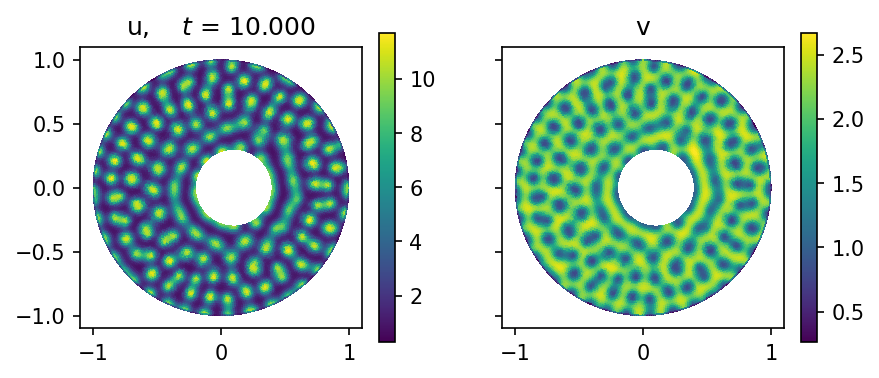

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'u,    $t$ = 10.000'}>,
        <Axes: title={'center': 'v'}>], dtype=object))

In [23]:
disp(mmesh2,gfu,10)  # worked but is not smooth and boundary does not look great
# still we could perhaps more easily make a movie this way by storing pngs than exporting vtks and using paraview

In [24]:
# remake everything!
dt = 0.01  # timestep
D_u = 1.0e-3  # diffusion coefficients for reaction diffusion equations 
D_v = D_u*11
rdtype = 'Br'   # doing a Brusselator reaction diffusion model 
#print(maxh_mesh**2/D_u,maxh_mesh**2/D_v )  # both of these should be larger than dt
# this is a CFL like condition for numerical stability
# CHECK that our dt is lower than these !!!!!!

# we define dt, D_u, D_v here because we need them to construct matrices 
# no boundary condition is yet specified which means we have a natural (zero Neumann) boundary condition 

# make the operators 
invastar,b,invm = mkops(fes,D_u,D_v,dt)

gfu_b = ngsolve.GridFunction(fes) # to hold the solution 

# output fields 
u1_out_b = gfu_b.components[0]
u2_out_b = gfu_b.components[1]

m.mat.nze = 2098140, a1.mat.nze=2098140
b.nze = 2098140
astar.nze=2098140


In [25]:

mkinit(gfu_b,0.1,4,1.5)  # make initial conditions and show them
scene1 = Draw(u1_out_b,mmesh, settings = {  "Colormap" : { "ncolors" : 20 } });  # 


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Colormap': {'ncolors': 20}},…

In [26]:
alpha = 5.; beta = 9.  # choose some nice Brusselator params
gfut_CN = TimeStepping_CN(gfu_b,invastar, b,invm, rdtype, alpha, beta, dt, tend=10,reaction_by_hand = False)
# run with non-linear operators instead of doing non-linear part by hand 

craete bilinearformapplication
 9.99000000000000153

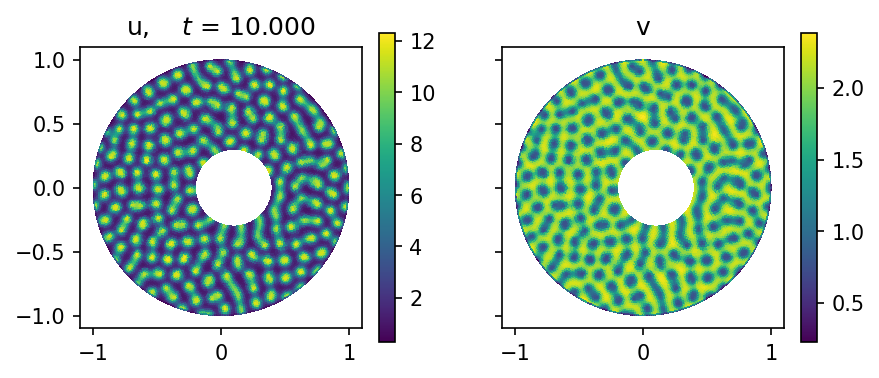

(<Figure size 900x450 with 4 Axes>,
 array([<Axes: title={'center': 'u,    $t$ = 10.000'}>,
        <Axes: title={'center': 'v'}>], dtype=object))

In [27]:
disp(mmesh2,gfu_b,10)